Трансфероное обучение. <br>
Используя предобученные нейронные сети для задачи классификации изображений подобрать модель таким образом, чтобы метрики качества были максимальны.<br>
Вывести графики обучения. Проанализировать результат.<br> Использовать колбеки для изменения скорости обучения и сохраннеия лучшей модели. <br>
Испаользовать набор данных с EuroSat.

In [ ]:
from google.colab import drive
from tensorflow.keras.callbacks import ModelCheckpoint
from tqdm import tqdm

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

import zipfile
import random
import cv2
import os


Разархивируем изображения, создадим массивы с картинками и соответствующими метками классов, сохраним массивы в npz-файл, чтобы в следующий раз не считывать с диска.

In [ ]:
mount_point = '/content/drive'

if not os.path.exists(mount_point):
    os.mkdir(mount_point)

drive.mount(mount_point)


In [ ]:
# initialize constants
ZIP_PATH = '/content/drive/MyDrive/peleng-courses/HW_23/EuroSAT.zip'
EXTRACT_PATH = '/'.join(ZIP_PATH.split('/')[:-1])

TRAIN_VAL_SPLIT = 0.8
VAL_SPLIT = 0.2


In [ ]:
# extract pictures from archive
def extract_archive():
    for item in os.listdir(EXTRACT_PATH):
        if os.path.isdir(os.path.join(EXTRACT_PATH, item)):
            return

    with zipfile.ZipFile(ZIP_PATH, 'r') as archive:
        archive.extractall(EXTRACT_PATH)


In [ ]:
extract_archive()


In [ ]:
# open images and set labels
dataset_path = None
for item in os.listdir(EXTRACT_PATH):
    if os.path.isdir(os.path.join(EXTRACT_PATH, item)):
        dataset_path = os.path.join(EXTRACT_PATH, item)

classes = list()
labels = np.array([])
images = np.array([])

for class_name in os.listdir(dataset_path):
    classes.append(class_name)
    label = len(classes) - 1

    for image_name in tqdm(os.listdir(os.path.join(dataset_path, class_name))):
        image = cv2.imread(os.path.join(dataset_path, class_name, image_name))

        if images.size == 0:
            images = np.array([image])
        else:
            images = np.vstack([images, [image]])

        if labels.size == 0:
            labels = np.array([label])
        else:
            labels = np.vstack([labels, [label]])

print('\nImages count is', images.shape[0],
      '\nClasses count is', len(classes))


100%|██████████| 2500/2500 [06:42<00:00,  6.21it/s]


Images count is 27000 
Classes count is 10


In [ ]:
# save dataset to npz-file
npz_path = os.path.join(EXTRACT_PATH, 'imgset.npz')
# np.savez(npz_path, images=images, labels=labels, classes=classes)


In [ ]:
# load images data from npz-file
data = np.load(npz_path)
images = data['images']
labels = data['labels']
classes = data['classes']


In [ ]:
_, h, w, c = images.shape
print(f'{h}x{w}x{c}')


64x64x3


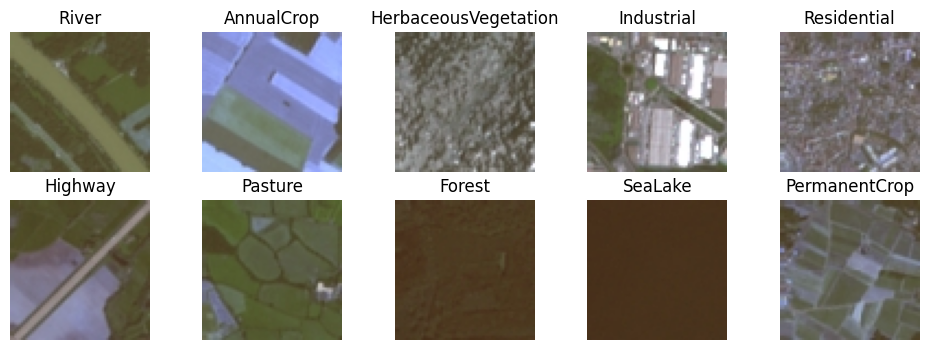

In [ ]:
# visualize dataset images
plt.figure(figsize=(12, 4))

step = 2900
for i in range(0, len(images), step):
    plt.subplot(2, 5, i // step + 1)
    plt.imshow(images[i])
    plt.title(classes[labels[i, 0]])
    plt.axis('off')


Случайным образом разделим набор изображений на обучающую и тестовую выборки. <br>
Создадим слои аугментации: случайные перевороты по вертикали и горизонтали, случайные повороты и масштабирования.

In [ ]:
# split dataset into train-val and test
train_val_idxs = random.sample(range(len(images)),
                               int(len(images) * TRAIN_VAL_SPLIT))
test_idxs = list(set(range(len(images))).difference(train_val_idxs))

train_val_images = images[train_val_idxs]
train_val_labels = labels[train_val_idxs]

test_images = images[test_idxs]
test_labels = labels[test_idxs]

print('Train-val set length is', train_val_labels.shape[0],
      '\nTest set length is', test_labels.shape[0])

assert train_val_labels.shape[0] + test_labels.shape[0] == labels.shape[0], '[WARNING] Check splits'


Train-val set length is 21600 
Test set length is 5400


In [ ]:
# create augmentation layers
def create_aug_layers():
    augmentation_layers = tf.keras.Sequential([
        tf.keras.layers.RandomFlip(mode='horizontal_and_vertical'),
        tf.keras.layers.RandomRotation(0.4, fill_mode='nearest'),
        tf.keras.layers.RandomZoom(height_factor=(0.05, 0.2),
                                   width_factor=(0.05, 0.2))
    ])

    return augmentation_layers


In [ ]:
augmentation_layers = create_aug_layers()
augmentation_layers.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation (RandomRotation)     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom (RandomZoom)             │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Для извлечения признаков изображений используем модели из tensorflow.keras: MobileNet, NASNetMobile и DenseNet121.<br>
Каждую из моделей включим в архитектуру совместно со слоями Resizing (для MobileNet, который не имеет предобученных весов размерностью 64х64), слоями аугментации, слоями Flatten и Dense для классификации признаков.

In [ ]:
# get pratrained MobileNet model
mobilenet_layers = tf.keras.applications.MobileNet(input_shape=(128, 128, c,),
                                                   include_top=False)
mobilenet_layers.trainable = False
mobilenet_layers.summary()


In [ ]:
# create general model with augmentation and classification layers
mobilenet_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(h, w, c,)),
    tf.keras.layers.Resizing(height=128, width=128, interpolation='bicubic'),
    augmentation_layers,
    mobilenet_layers,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(len(classes), activation='softmax')
])

mobilenet_model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resizing (Resizing)                  │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenet_1.00_128 (Functional)      │ (None, 4, 4, 1024)          │       3,228,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 10)                  │         163,850 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,392,714 (12.94 MB)

 Trainable params: 163,850 (640.04 KB)

 Non-trainable params: 3,228,864 (12.32 MB)

Делаем предобработку данных перед тем, как пропустить через модель. Функция предобработки данных для MobileNet приводит значения пикселей изображений к диапазону [-1, 1].

In [ ]:
preproc_train_val_images_mobilenet = tf.keras.applications.mobilenet.preprocess_input(train_val_images.copy())


Industrial:



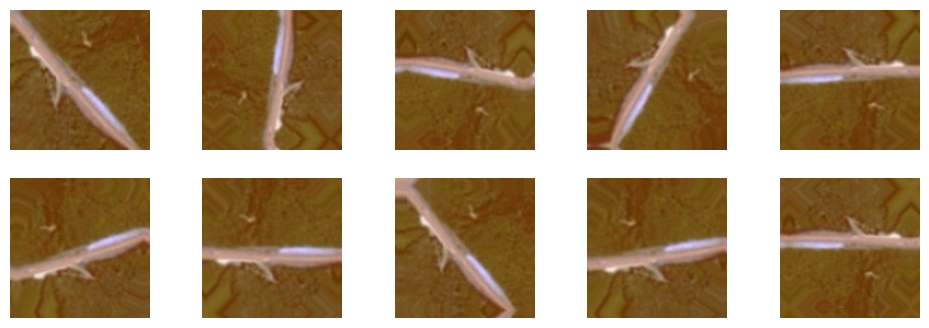

In [ ]:
# show augmentation example
plt.figure(figsize=(12, 4))

n = 10150
resize_layer = tf.keras.layers.Resizing(height=128, width=128,
                                        interpolation='bicubic')
image = resize_layer(tf.reshape(preproc_train_val_images_mobilenet[n],
                                shape=(1, h, w, c)))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.axis('off')

    if not i == 0:
        one_image = augmentation_layers(image)[0].numpy()
    else:
        one_image = image[0].numpy()

    one_image = (one_image - one_image.min()) / (one_image.max() - one_image.min())
    plt.imshow(one_image)

print(f'{classes[labels[n, 0]]}:\n')


Используем косунусный регулятор для скорости обучения сети.

In [ ]:
# create scheduler for decrease learning rate
mobilenet_batch = 128

cosine_scheduler = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=0.001,
    warmup_target=0.01,
    warmup_steps=len(train_val_images) // mobilenet_batch * 10,
    decay_steps=len(train_val_images) // mobilenet_batch * 20,
    alpha=0.1
)

mobilenet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=cosine_scheduler),
                        loss='sparse_categorical_crossentropy',
                        metrics=['accuracy'])

model_path = os.path.join(EXTRACT_PATH, 'mobilenet_best.keras')
model_saving = ModelCheckpoint(model_path, save_best_only=True,
                               monitor='val_loss', mode='min')


In [ ]:
# train model with MobileNet
mobilenet_epohcs = 30
history = mobilenet_model.fit(x=preproc_train_val_images_mobilenet,
                              y=train_val_labels,
                              batch_size=mobilenet_batch,
                              epochs=mobilenet_epohcs,
                              validation_split=VAL_SPLIT,
                              callbacks=[model_saving])


In [ ]:
# function for visualizaton train history plots
def visualize_curve(history_dict, title, x_max_lim):
    plt.plot(history_dict['accuracy'], color='deeppink')
    plt.plot(history_dict['val_accuracy'], color='red')
    plt.gca().xaxis.set_major_locator(plt.MultipleLocator(10))
    plt.gca().yaxis.set_major_locator(plt.MultipleLocator(0.1))
    plt.legend(['Train', 'Val'])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.xlim(0, x_max_lim)
    plt.ylim(0, 1)
    plt.title(title)
    plt.show()


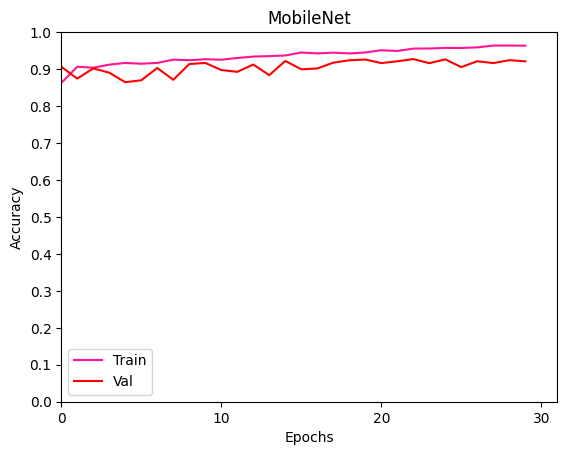

In [ ]:
visualize_curve(history.history, 'MobileNet', mobilenet_epohcs + 1)


Как видно из графика обучения выше, модель с MobileNet в основе достигает точности около 0.9 для валидационной выборки даже раньше 30ой эпохи. 20 эпох достаточно для ее обучения.

In [ ]:
# load best model with MobileNet
best_mobilenet = tf.keras.models.load_model(model_path)


In [ ]:
preproc_test_images_mobilenet = tf.keras.applications.mobilenet.preprocess_input(test_images.copy())

# evaluate model with MobileNet
metrics = best_mobilenet.evaluate(preproc_test_images_mobilenet, test_labels)

# save model metric to dict
metrics_dict = {'MobileNet': metrics[1]}


169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.8893 - loss: 0.5076


In [ ]:
# get pretrained NASNetMobile model
nasnetmobile_layers = tf.keras.applications.NASNetMobile(input_shape=(h, w, c,),
                                                         include_top=False)
nasnetmobile_layers.trainable = False
nasnetmobile_layers.summary()


In [ ]:
# create general model with augmentation and classification layers
nasnetmobile_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(h, w, c,)),
    create_aug_layers(),
    nasnetmobile_layers,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(len(classes), activation='softmax')
])

nasnetmobile_model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)            │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ nasnet_mobile (Functional)           │ (None, 2, 2, 1056)          │       4,269,716 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 4224)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │          42,250 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,311,966 (16.45 MB)

 Trainable params: 42,250 (165.04 KB)

 Non-trainable params: 4,269,716 (16.29 MB)

Используем экспоненциальный регулятор для изменения скорости обучения сети.

In [ ]:
# create scheduler for decrease learning rate
nasnetmobile_batch = 128

exponential_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=len(train_val_images) // nasnetmobile_batch * 10,
    decay_rate=0.98,
    staircase=True
)

nasnetmobile_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=exponential_scheduler),
                           loss='sparse_categorical_crossentropy',
                           metrics=['accuracy'])

model_path = os.path.join(EXTRACT_PATH, 'nasnetmobile_best.keras')
model_saving = ModelCheckpoint(model_path, save_best_only=True,
                               monitor='val_loss', mode='min')


Делаем предобработку данных перед тем, как пропустить через модель. Функция предобработки данных для NASNetMobile приводит значения пикселей изображений к диапазону [-1, 1].

In [ ]:
preproc_train_val_images_nasnetmobile = tf.keras.applications.nasnet.preprocess_input(train_val_images.copy())


In [ ]:
# train model with NASNetMobile
nasnetmobile_epochs = 20
history = nasnetmobile_model.fit(x=preproc_train_val_images_nasnetmobile,
                                 y=train_val_labels,
                                 batch_size=nasnetmobile_batch,
                                 epochs=nasnetmobile_epochs,
                                 validation_split=VAL_SPLIT,
                                 callbacks=[model_saving])


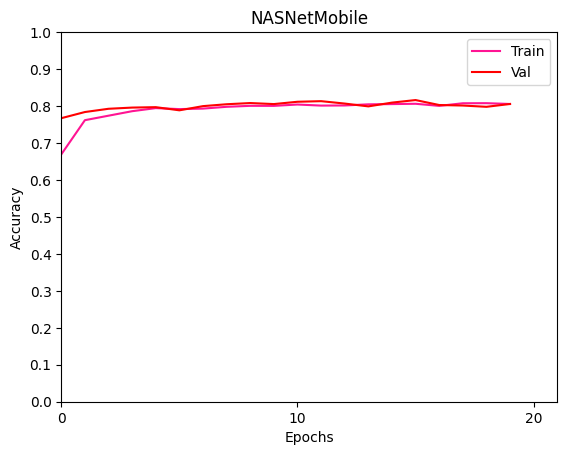

In [ ]:
visualize_curve(history.history, 'NASNetMobile', nasnetmobile_epochs + 1)


Из графика обучения выше видно, что модель с NASNetMobile в основе достигает точности около 0.8 для валидационной и обучающей выборкок и перестает улучшать метрики даже раньше 10ой эпохи.

In [ ]:
# load best model with NASNetMobile
best_nasnetmobile = tf.keras.models.load_model(model_path)


In [ ]:
preproc_test_images_nasnetmobile = tf.keras.applications.nasnet.preprocess_input(test_images.copy())
metrics = best_nasnetmobile.evaluate(preproc_test_images_nasnetmobile, test_labels)
metrics_dict.update({'NASNetMobile': metrics[1]})


169/169 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.8337 - loss: 0.5500


In [ ]:
# get pretrained DenseNet121 model
densenet_layers = tf.keras.applications.DenseNet121(input_shape=(h, w, c,),
                                                    include_top=False)
densenet_layers.trainable = False
densenet_layers.summary()


In [ ]:
# create general model with augmentation and classification layers
densenet_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(h, w, c,)),
    create_aug_layers(),
    densenet_layers,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(len(classes), activation='softmax')
])

densenet_model.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_4 (Sequential)            │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ densenet121 (Functional)             │ (None, 2, 2, 1024)          │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │          40,970 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,078,474 (27.00 MB)

 Trainable params: 40,970 (160.04 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

Используем регулятор с обратной зависимостью от времени для уменьшения скорости обучения модели.

In [ ]:
# create scheduler for decrease learning rate
densenet_batch = 128

inverse_time_scheduler = tf.keras.optimizers.schedules.InverseTimeDecay(
    initial_learning_rate=0.001,
    decay_steps=len(train_val_images) // densenet_batch * 10,
    decay_rate=0.96
)

densenet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=inverse_time_scheduler),
                       loss='sparse_categorical_crossentropy',
                       metrics=['accuracy'])

model_path = os.path.join(EXTRACT_PATH, 'densenet_best.keras')
model_saving = ModelCheckpoint(model_path, save_best_only=True,
                               monitor='val_loss', mode='min')


Делаем предобработку данных перед тем, как пропустить через модель. Функция предобработки данных для DenseNet121 приводит значения пикселей изображений к диапазону [0, 1].

In [ ]:
preproc_train_val_images_densenet = tf.keras.applications.densenet.preprocess_input(train_val_images.copy())


In [ ]:
# train model with DenseNet121
densenet_epochs = 50
history = densenet_model.fit(x=preproc_train_val_images_densenet,
                             y=train_val_labels,
                             batch_size=densenet_batch,
                             epochs=densenet_epochs,
                             validation_split=VAL_SPLIT,
                             callbacks=[model_saving])


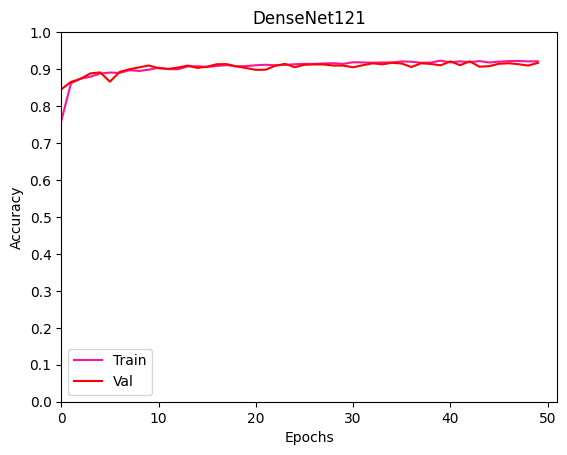

In [ ]:
visualize_curve(history.history, 'DenseNet121', densenet_epochs + 1)


Как видно из графика обучения выше, модель с DenseNet121 в основе достигает точности около 0.9 для валидационной и обучающей выборок даже раньше 20ой эпохи. 20 эпох достаточно для ее обучения.

In [ ]:
best_densenet = tf.keras.models.load_model(model_path)


In [ ]:
preproc_test_images_densenet = tf.keras.applications.densenet.preprocess_input(test_images.copy())
metrics = best_densenet.evaluate(preproc_test_images_densenet, test_labels)
metrics_dict.update({'DenseNet121': metrics[1]})


169/169 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.9254 - loss: 0.2280


In [ ]:
print('KERAS MODEL\t| TEST ACCURACY')
print('----------------------------------')

for model_name, acc in metrics_dict.items():
    print(f'{model_name}\t| {acc}')


KERAS MODEL	| TEST ACCURACY
----------------------------------
MobileNet	| 0.914814829826355
NASNetMobile	| 0.8240740895271301
DenseNet121	| 0.9164814949035645


В работе рассмотрено три модели из библиотеки tensorflow.keras.applications: MobileNet, NASNetMobile, DenseNet121.<br>
Для снижения скорости обучения в сочетании с этими моделями рассмотрены регуляризаторы CosineDecay, ExponentialDecay, InverseTimeDecay.<br>
Из итоговой таблицы видно, что лучше всего классифицировала изображения тестовой выборки модель, использующая DenseNet121 для извлечения признаков.